## Recopilación del Dataset 

In [11]:
import cv2

cam = cv2.VideoCapture(0)
currentframe = 0

while (True):
    ret, frame = cam.read()
    name = './data/Sad/ne' + str(currentframe) + '.jpg'
    print('Creating...' + name)
    cv2.imwrite(name, frame)
    currentframe += 1
    if currentframe>380:
        break
    cv2.imshow('img', frame)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

cam.release()
cv2.destroyAllWindows()
print()

Creating..../data/Sad/ne0.jpg
Creating..../data/Sad/ne1.jpg
Creating..../data/Sad/ne2.jpg
Creating..../data/Sad/ne3.jpg
Creating..../data/Sad/ne4.jpg
Creating..../data/Sad/ne5.jpg
Creating..../data/Sad/ne6.jpg
Creating..../data/Sad/ne7.jpg
Creating..../data/Sad/ne8.jpg
Creating..../data/Sad/ne9.jpg
Creating..../data/Sad/ne10.jpg
Creating..../data/Sad/ne11.jpg
Creating..../data/Sad/ne12.jpg
Creating..../data/Sad/ne13.jpg
Creating..../data/Sad/ne14.jpg
Creating..../data/Sad/ne15.jpg
Creating..../data/Sad/ne16.jpg
Creating..../data/Sad/ne17.jpg
Creating..../data/Sad/ne18.jpg
Creating..../data/Sad/ne19.jpg
Creating..../data/Sad/ne20.jpg
Creating..../data/Sad/ne21.jpg
Creating..../data/Sad/ne22.jpg
Creating..../data/Sad/ne23.jpg
Creating..../data/Sad/ne24.jpg
Creating..../data/Sad/ne25.jpg
Creating..../data/Sad/ne26.jpg
Creating..../data/Sad/ne27.jpg
Creating..../data/Sad/ne28.jpg
Creating..../data/Sad/ne29.jpg
Creating..../data/Sad/ne30.jpg
Creating..../data/Sad/ne31.jpg
Creating..../data/

## Preprocesamiento del Dataset 

In [1]:
import cv2
import os

data_path='data'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'Angry': 0, 'Neutral': 1, 'Sad': 2, 'Smile': 3}
['Angry', 'Neutral', 'Sad', 'Smile']
[0, 1, 2, 3]


In [2]:
img_size=100
data=[]
target=[]

facedata = "haarcascade_frontalface_alt.xml"
cascade = cv2.CascadeClassifier(facedata)


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)
        faces = cascade.detectMultiScale(img)
        try:
            for f in faces:
                x, y, w, h = [v for v in f]
                sub_face = img[y:y + h, x:x + w]
                gray=cv2.cvtColor(sub_face,cv2.COLOR_BGR2GRAY)           
                #Coverting the image into gray scale
                resized=cv2.resize(gray,(img_size,img_size))
                data.append(resized)
                target.append(label_dict[category])
        except Exception as e:
            print('Exception:',e)

In [3]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

Using TensorFlow backend.
C:\Users\Diego\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Diego\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Diego\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Diego\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [5]:
np.save('./training/data',data)
np.save('./training/target',new_target)

## Entrenamiento de la Red Neuronal Convolucional

In [6]:
import numpy as np

data=np.load('./training/data.npy')
target=np.load('./training/target.npy')

In [7]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(4,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [8]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [16]:
checkpoint = ModelCheckpoint('./training/model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=12,callbacks=[checkpoint],validation_split=0.2)

Train on 120 samples, validate on 31 samples
Epoch 1/12
120/120 [==============================] - 6s 46ms/step - loss: 1.1792 - accuracy: 0.4667 - val_loss: 1.4231 - val_accuracy: 0.2903
Epoch 2/12
120/120 [==============================] - 6s 47ms/step - loss: 1.1296 - accuracy: 0.5083 - val_loss: 1.4737 - val_accuracy: 0.2581
Epoch 3/12
120/120 [==============================] - 5s 45ms/step - loss: 1.0983 - accuracy: 0.5167 - val_loss: 1.4301 - val_accuracy: 0.3871
Epoch 4/12
120/120 [==============================] - 6s 46ms/step - loss: 1.0325 - accuracy: 0.5917 - val_loss: 1.4788 - val_accuracy: 0.3548
Epoch 5/12
120/120 [==============================] - 5s 45ms/step - loss: 0.9635 - accuracy: 0.6250 - val_loss: 1.6260 - val_accuracy: 0.2903
Epoch 6/12
120/120 [==============================] - 5s 45ms/step - loss: 0.8805 - accuracy: 0.7000 - val_loss: 1.5439 - val_accuracy: 0.3871
Epoch 7/12
120/120 [==============================] - 6s 47ms/step - loss: 0.8463 - accuracy: 0.7

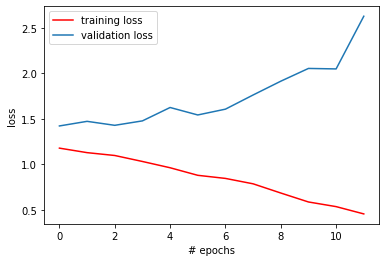

In [17]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

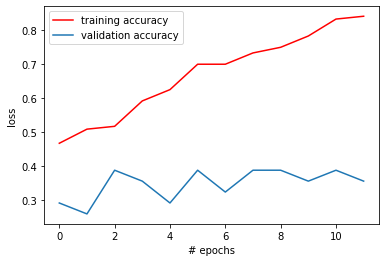

In [18]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [19]:
print(model.evaluate(test_data,test_target))

17/17 [==============================] - 0s 13ms/step
[1.9208288192749023, 0.29411765933036804]


## Cargar el modelo

In [20]:
from keras.models import load_model
import cv2
import numpy as np

In [22]:
model = load_model('./training/model-002.model')

face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')

cap=cv2.VideoCapture("vb1.mp4")
# size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'x264' doesn't work
# out = cv2.VideoWriter('test1.mp4',fourcc, 29.0, size)  # 'False' for 1-ch instead of 3-ch for color


labels_dict={0:'Angry',1:'Neutral',2:'Sad',3:"Smile"}
color_dict={0:(0,0,255),1:(0,255,0),2:(255,0,0),3:(255,0,255)}

In [23]:
while(True):

    ret,img=cap.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,3)  

    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
#     out.write(img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
    if ret==False:
        break
        
cv2.destroyAllWindows()
cap.release()